# Random Fantasy Map Generator

## Inspiration

I wanted to make maps that look like something you'd find at the back of one of the cheap paperback fantasy novels of my youth. I always had a fascination with these imagined worlds, which were often much more interesting than whatever luke-warm sub-Tolkien tale they were attached to.

At the same time, I wanted to play with terrain generation with a physical basis. There are loads of articles on the internet which describe terrain generation, and they almost all use some variation on a fractal noise approach, either directly (by adding layers of noise functions), or indirectly (e.g. through midpoint displacement). These methods produce lots of fine detail, but the large-scale structure always looks a bit off. Features are attached in random ways, with no thought to the processes which form landscapes. I wanted to try something a little bit different.

There are a few different stages to the generator. First we build up a height-map of the terrain, and do things like routing water flow over the surface. Then we can render the 'physical' portion of the map. Finally we can place cities and 'regions' on the map, and place their labels.

In [11]:
import random
from scipy.spatial import Voronoi, voronoi_plot_2d
from functools import reduce

defaultExtent = {
    "width": 1,
    "height": 1
}

def improvePoints(pts, n=1, extent=defaultExtent):
    vor = Voronoi(pts)
    p = vor.points
    # print(list(p))
    return pts

def generatePoints(n, extent=defaultExtent):
    pts = []
    for i in range(n):
        pts.append([(random.random()- 0.5) * extent["width"], (random.random() - 0.5) * extent["height"]])
    return pts

def generateGoodPoints(n, extent=defaultExtent):
    pts = generatePoints(n, extent)
    sorter = lambda x: x[0]
    pts = sorted(pts, key=sorter)
    return improvePoints(pts, 1, extent)


points = generateGoodPoints(4096)


## Grids

To represent the heightmap, first we need a grid of points. Although it can be simpler to work on a regular square grid, I much prefer to work on an irregular set of points for something like this. With a regular grid, it's very easy to run into weird artifacts, and you often have to do a lot of postprocessing to hide the effects of the grid. If you use an irregular grid, then there are a few things which are more complicated, but the structure of the grid helps to give the map a rough, organic feel, and you never have to worry about nasty linear artifacts in the finished product.

The approach I use is the same as in this [article](http://www-cs-students.stanford.edu/~amitp/game-programming/polygon-map-generation/), which is one of the better references out there on how to do non-fractal terrain generation. I won't go into too much detail here because that article explains it very clearly, with lots of diagrams.

I start by selecting points at random within the map. These points tend to be a bit clumpy and uneven, so I use [Lloyd relaxation](https://en.wikipedia.org/wiki/Lloyd%27s_algorithm) to improve the point set. For speed, I only use one iteration of this process, but you can repeat it as many times as you like. There are rapidly diminishing returns after a few iterations though.

All of the calculations are actually carried out on the 'dual points' of the original point set, which correspond to the corners of the Voronoi polygons. This has the advantage that the number of neighbours per node is fixed at three, which helps in some parts of the code.

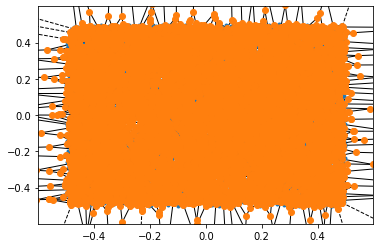

In [12]:
vor = Voronoi(points)
fig = voronoi_plot_2d(vor)

## Rough outlines

One of the difficulties of creating landscapes in a realistic way is that real landscapes aren't created all at once. Instead, they evolve from earlier landscapes, which in turn evolved from even earlier landscapes, and so on back for billions of years. There's no good way to simulate this process in a reasonable amount of time, so we need to cheat slightly.

Rather than an infinite regress of older landscapes, I start with a simple 'proto-landscape', built with geometric primitives. This lets me control the broad outlines of the terrain, while leaving the details for the more physical processes to fill in later.

Some useful primitives which we can add together:

- Constant slope - if you want to pretend this is physically motivated, think of it as tectonic uplift on one side of the map
- Cone shapes - these can be islands or mountains, or if inverted, lakes or seas
- Rounded blobs - these make better hills, and can be scattered all around to make a noisy surface

We also have a few operations which are handy:

- Normalize - rescale the heights to lie in the range 0-1
- Round - normalize, then take the square root of the height value, to round off the tops of hills
- Relax - replace each height value with the average of its neighbours, to smooth the surface
- Set sea level - translate the heightmap up or down so that a particular quantile is at zero

The particular sequence of primitives and operations used can be varied to produce different kinds of landscape, such as coastlines, islands and mountain ranges.

## Erosion

The results of this process can be a little bit on the blobby side, which means they rarely look good on their own. We want to scuff them up a bit, so they look more like real landscapes. We do this by applying an erosion operation.

In most of the world, by far the largest influence on the shape of landforms is fluvial (water-based) erosion. Water flows downhill, carrying sediment along with it, carving out valleys and river basins. This is a massively complex phenomenon, and modelling it correctly is a very active research area, but we can get a long way by sketching a simple version of the process.

We need to start by tracing the routes that water would take over the grid. For each grid point, we say that water flows to its lowest neighbour, and so on down until we reach the edge of the map. This gives a map of water flow.

There's an obvious problem when we reach gridpoints which are lower than all of their neighbours. Do we route the water back uphill? This will probably lead to cycles in the water system, which are trouble. Instead, we want to fill in these gaps (often called sinks or depressions), so that the water always runs downhill all the way to the edge.

It's easy to see how to fill in a single gridpoint, but as the depression gets bigger, and possibly links up with other depressions, the number of possible cases multiplies enormously. Luckily, there's an algorithm for filling depressions, called the Planchon-Darboux algorithm.

> Aside: the Planchon-Darboux algorithm
> The algorithm works by finding the lowest surface with the following two properties:
> 
> - The surface is everywhere at least as high as the input surface
> - Every non-edge point has a neighbour which is lower than it
> To calculate this, we start with an infinitely high surface everywhere except on the edge, where we use the original heights. Then, on each iteration, we find points which have a neighbour which is lower than them, and set their height to their original height, or the height of their lowest neighbour (plus a small amount), whichever is higher. We halt when we can go a full iteration without changing any point.
> 
> There are various ways of speeding up this algorithm, mostly by tweaking the order in which points are visited. For more details, and a proof of correctness, you can read the original paper.

With the water routing calculated, we can work out how much water is flowing through each point. I assume that rainfall is constant across the whole map, and iterate through the points in descending order, passing the rainfall, plus the accumulated water flux, from each point to its 'downhill point'. This gives a map of water flux, which usually converges into a nice branching river structure, with lots of small streams feeding a larger central channel.

To calculate erosion, I combine the water flux with the slope at each point, as calculated based on the triangle of its neighbours. The exact formula I use is the product of the slope with the square root of the water flux. This isn't necessarily very physical, but it does give nice-looking results. I also add a small term which is proportional to the slope squared. This prevents deep gorges from forming, which might be physically realistic, but don't look good in the graphical style I've chosen.

I find it's very important to cap the erosion rate, otherwise strange things can happen. A little goes a very long way with this. Also, erosion always lowers the surface, so it usually helps to drop the sea level afterwards to match.

A final tweak to the heightmap is to smooth out the coastlines slightly. The erosion tends to produce quite rough terrain, which becomes tiny islands when cut off by sea level. A few of these can look good, but too many just looks messy. I repeatedly apply a filter where points which are below sea level, but a majority of whose neighbours are above sea level, get pulled up, and vice versa for points which are above sea level and have undersea neighbours. A couple of repeats of this produces a much cleaner coastline.



## Rendering terrain

Now comes the question of drawing the map (at least the physical portion). The easy part is the coastline - we've been doing this already. It's just a matter of drawing line segments where the heightmap crosses zero. There's not a lot extra to do about this.

The next component is the rivers. We don't want to display the entire drainage network, because that would cover the whole map. Instead, we only show the drainage from points with above a certain threshold of water flux. By connecting these points to their downstream neighbours, we can trace out the river paths.

One problem with this approach is that the rivers tend to zigzag from grid point to grid point, rather than following a smooth path. To solve this, I relax the points in the middle of the path towards their upstream and downstream neighbours (keeping the top and bottom fixed, so that intersections work properly). This smooths things out beautifully.

The final part of this is the shading on the sides of hills, which helps indicate the topography. It is a central principle of cartography that we tend to interpret maps as though viewing the terrain from the bottom of the map, looking towards the top. So we want to draw strokes which go up and right if the terrain slopes upwards from left to right, and down and right if the terrain slopes downwards. Similarly, the strokes on the 'near' side of hills should be longer than those on the 'far' side.

For each grid point, I calculate the slope, and ignore the point if it is less than a random threshold. For points which pass this test, I draw a short stroke with slope proportional to the horizontal component of the heightmap slope, with a small modifier for the vertical component. If the stroke would be too steep, I split it into several shorter strokes, at the maximum slope, drawn at random around the point.

## Cities, borders

Now that we have the 'physical' portion of the map sorted, we can move to looking at the 'political'. We want to place cities and towns on the map in feasible-looking locations. At the same time, we want the cities to be spread out enough that we can put labels on them without worrying too much about overlap.

To place a city, I generate a score for each point, which is a combination of three things:

- Water flux - we want cities to be preferentially located on rivers, so high water flux gets a bonus
- Distance from other cities - we want cities to be spread out, so penalize locations which are too close to an existing city
- Distance from the edge of the map - the other two criteria alone tend to push cities to the map edge, which isn't ideal, so penalize locations too close to the edge

Every time I add a city, I choose the point with the highest score, then recalculate the scores for all points. I make a distinction between cities, which have a 'region' associated with them, and towns, which don't. The cities are placed first, but otherwise there's no distinction in the code.

The next step is to mark out the regions. We want the borders between regions to seem fairly reasonable, following natural borders like rivers and mountain ranges. The way I approach this is to expand regions outwards from each city, so that each region consists of the points which are 'closest' to its city, according to a particular distance measure. This distance measure is calculated by adding up the cost of the route, based on these criteria:

- Horizontal distance
- Slope - uphill is much cheaper than downhill, so regions expand until they hit the top of ridges, then stop
- Water flux - crossing a river is expensive
- Shorelines - there is a large penalty for going from land to water (or vice versa), and a smaller penalty for travelling by water

Finally, the borders are drawn, using the same smoothing technique as the rivers.

## Placing labels

At this point we can start naming things, using the process described in [these notes](https://mewo2.com/notes/naming-language/). I generate names for cities, towns and regions, using a consistent language for the whole map.

The very last part of the process is to place the labels, avoiding overlaps, obscured cities, labels going off the edge of the map, etc. This sounds easy, but it really really isn't. Ideally, some sort of intelligent layout algorithm would place all the labels, rearranging as necessary. Instead, I have a few hundred lines of spaghetti code which seems to get the right answer most of the time, but which is packed full of magic numbers.

In rough outline, what happens is this: the labels are placed in the order 1. cities, 2. towns, 3. regions. For cities and towns, there are four possible slots for the label, above, below, and to each side of the marker. Each label is placed, attempting to avoid the following overlaps (in rough order of importance):

- City markers
- Other city labels
- The map edge
- Borders
- Coastlines
- Rivers

Obviously it's not usually possible to avoid all of these, so the least bad solution is chosen.

For regions, there's a bit more freedom in where to place the label, but the labels are also bigger, and the map is more cluttered at this point. The scoring system rates positions based on proximity to the center of the region, as well as being over land, and penalties for all the overlaps mentioned before.